In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

In [297]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [242]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [122]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [195]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [333]:
# Replace 'file_path.csv' with the path to your CSV file
file_path = '/mnt/raid1/thalassini/home/filtered_fimo/CTCF/datasets/data.csv'
df = pd.read_csv(file_path)
df

,data,class
0,CAAAAACACTGACAGGAAAAGGGATGGACATGATTCCCAGAATCCT...,0
1,CTAACCTGACATGAATTAGGGCAGGTTTTTGAATTCGTGTTGAAAA...,0
2,TCCTCTGTAGCACAGGTTAACACTTCTGCTAGTTCCAGGACTGAGG...,0
3,GAACACATTAAACAGCAGGTTGCTTATTCCTTCTCAAACCGCACTA...,0
4,ATTTCTCGGAACAGGCAGAAAGGAAGCGGCAGGGAGGTGGGTACTC...,0
...,...,...
96489,CCACCCTCCACTCCTCACCCCTCATCCCTCACCACCTGCCTTTCAA...,1
96490,GGCGGTGACGCACGGCGCGGTGACGCAGCGCGACGGCGGCGGCGGC...,1
96491,GGCGGTGACGCACGGCGCGGTGACGCAGCGCGACGGCGGCGGCGGC...,1
96492,CTCCCTCTCTGATGCCTGGTCACACCAGGATGGCGGTACCATGTGC...,1


Max length:218, Min length: 200


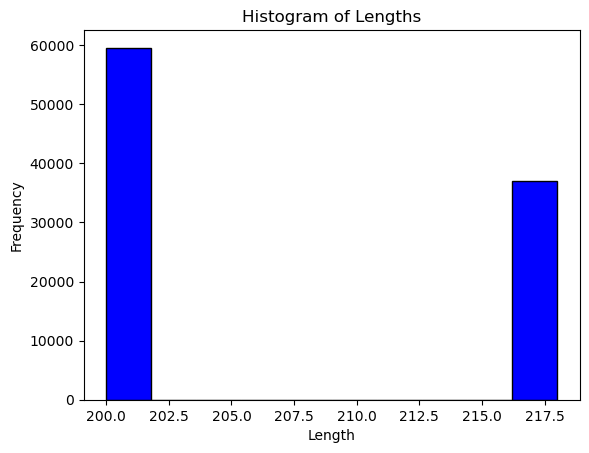

In [334]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [335]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [336]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Define X,y variables

In [337]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [339]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [341]:
X.shape

(96494, 200, 4)

In [342]:
y=np.array(df['class'])
y[:3]

array([0, 0, 0])

In [343]:
y = torch.from_numpy(y).type(torch.float)

In [348]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit



# Split the data into a stratified hold-out validation set and the rest
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_val_index, test_index in stratified_splitter.split(X, y):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))
print(len(X_test), len(y_test))


# (X_train, X_val, y_train, y_val) for training, validation
# X_test, y_test for the final hold-out validation.

X_train, X_val, X_test = torch.from_numpy(X_train).type(torch.float),torch.from_numpy(X_val).type(torch.float), torch.from_numpy(X_test).type(torch.float)



61756 61756 15439 15439
19299 19299


In [350]:
torch.manual_seed(42)
# Expand the dimensions of y_train to make it 2-dimensional
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1,1)
y_val = y_val.view(-1,1)
# Concatenate the complement of y_train to create a 2-dimensional tensor
y_train_one_hot = torch.cat([1 - y_train, y_train], dim=1).float()
y_test_one_hot = torch.cat([1 - y_test, y_test], dim=1).float()
y_val_one_hot = torch.cat([1 - y_val, y_val], dim=1).float()


# Move tensors to the same device
X_train, y_train_one_hot, y_train = X_train.to(device), y_train_one_hot.to(device), y_train.to(device)
X_val, y_val_one_hot, y_val = X_val.to(device), y_val_one_hot.to(device), y_val.to(device)
X_test, y_test_one_hot, y_test = X_test.to(device), y_test_one_hot.to(device), y_test.to(device)


print(X_train.size(0), y_train_one_hot.size(0), y_train.size(0))
# Create datasets
train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)
val_dataset = TensorDataset(X_val, y_val_one_hot, y_val)
test_dataset = TensorDataset(X_test, y_test_one_hot, y_test)



61756 61756 61756


In [352]:
from torch.utils.data import DataLoader, TensorDataset
batch_size=64
torch.manual_seed(42)
# Convert to PyTorch DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 1 layer CNN

In [320]:
class Conv_v0(torch.nn.Module):

    def __init__(self):
        super(Conv_v0, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels=3, kernel_size=17)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=5)
        
        self.dropout = torch.nn.Dropout(p=0.5) 
        self.fc = torch.nn.Linear(in_features=108, out_features=2)
        #elf.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
  
    
        
        x = self.fc(x)
       #x = self.sigmoid(x)
        return x


In [321]:
# Create an instance of the Conv_v0 model
torch.manual_seed(42)
model = Conv_v0()

# Generate random input data
random_data = torch.rand((61756, 200, 4))

# Pass the random data through the model
result = model(random_data)

print(result)


tensor([[-0.0455, -0.0595],
        [-0.1923, -0.6890],
        [-0.4030, -0.2121],
        ...,
        [-0.4391, -0.2598],
        [-0.2159, -0.1918],
        [-0.3173, -0.4356]], grad_fn=<AddmmBackward0>)


In [322]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.5399, -0.4358],
        [-0.1775, -0.1294],
        [-0.1751,  0.2937],
        [-0.0316,  0.0428],
        [-0.0760, -0.4730]], grad_fn=<SliceBackward0>)

# Computing class weights

In [373]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have defined your dataset
# train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)

# Extract the labels from the dataset
_, _, y_train = zip(*train_dataset)

# Count occurrences of each class
class_0_count = sum(1 for label in y_train if label == 0)
class_1_count = sum(1 for label in y_train if label == 1)

# Total length of y_train
total_samples = len(y_train)

# Calculate class weights
weights = [total_samples / class_0_count, total_samples / class_1_count]

# Print the list of class weights
print("Class Weights List:", weights)




Class Weights List: [2.6129045906494603, 1.6199994753547913]


# Set up loss function and optimizer

In [385]:
torch.manual_seed(42)
# Create an instance of the Conv_v0 model
model = Conv_v0()

In [384]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.001)

In [386]:
from torch.optim import lr_scheduler
weights = torch.tensor(weights).to(device)
print(weights)


# define the CrossEntropyLoss with weights
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

tensor([2.6129, 1.6200])


/tmp/ipykernel_2880998/579181073.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights).to(device)


In [387]:
torch.manual_seed(42)
# Training and evaluation loop
epochs = 10  # You can adjust the number of epochs
for epoch in range(epochs):
    ### Training
    model.train()

    for X_train, y_train_one_hot, y_train in train_loader:
        # Move data to the device if needed
        X_train, y_train = X_train.to(device), y_train.to(device)

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train)#.squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        #print(y_logits.shape,y_pred_class.shape,y_train.shape)
        


        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_train_one_hot)
        acc = balanced_accuracy(y_true=y_train.detach().numpy(), 
                                y_pred=y_pred_class.detach().numpy())

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        for X_val, y_val_one_hot, y_val in val_loader:
            # Move data to the device if needed
            X_val, y_val_one_hot, y_val = X_val.to(device), y_val_one_hot.to(device), y_val.to(device)

            # 1. Forward pass
            val_logits = model(X_val).squeeze()
            val_pred = torch.round(torch.sigmoid(val_logits))
            

            # 2. Calculate loss/accuracy
            val_loss = loss_fn(val_logits, y_val_one_hot)
            val_pred_class = torch.argmax(torch.softmax(val_pred, dim=1), dim=1)
        
            val_acc = balanced_accuracy(y_true=y_val.cpu().numpy(),
                                        y_pred=val_pred_class.cpu().numpy())

    # Print out what's happening every epoch
    print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2f}%")

Epoch: 1 | Train Loss: 1.45834, Train Acc: 44.86% | Val Loss: 1.49406, Val Acc: 50.00%
Epoch: 2 | Train Loss: 1.49370, Train Acc: 48.99% | Val Loss: 1.17994, Val Acc: 50.00%
Epoch: 3 | Train Loss: 1.47694, Train Acc: 54.71% | Val Loss: 1.39712, Val Acc: 50.00%
Epoch: 4 | Train Loss: 1.27093, Train Acc: 55.95% | Val Loss: 1.36225, Val Acc: 50.00%
Epoch: 5 | Train Loss: 1.35490, Train Acc: 42.34% | Val Loss: 1.29154, Val Acc: 50.00%
Epoch: 6 | Train Loss: 1.41643, Train Acc: 43.90% | Val Loss: 1.47488, Val Acc: 50.00%
Epoch: 7 | Train Loss: 1.32678, Train Acc: 50.40% | Val Loss: 1.31426, Val Acc: 55.00%
Epoch: 8 | Train Loss: 1.36151, Train Acc: 48.20% | Val Loss: 1.37517, Val Acc: 50.00%
Epoch: 9 | Train Loss: 1.39123, Train Acc: 52.99% | Val Loss: 1.27329, Val Acc: 50.00%
Epoch: 10 | Train Loss: 1.25620, Train Acc: 55.68% | Val Loss: 1.31147, Val Acc: 55.00%


# Define functions for training and testing

In [363]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_bal_acc, train_mcc, train_f_score = 0, 0, 0, 0

    # Loop through data loader data batches
    for batch, (X, y_one_hot, y) in enumerate(dataloader):
        # Move data to the device if needed
        X, y_one_hot, y = X.to(device), y_one_hot.to(device), y.to(device)

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X)#.squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        
        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_one_hot)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
       #train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        # get the balanced accuracy
        train_bal_acc += balanced_accuracy_score(y.cpu().numpy(), y_pred_class.cpu().numpy())
        train_mcc += matthews_corrcoef(y.cpu().numpy(), y_pred_class.cpu().numpy())
        train_f_score += f1_score(y.cpu().numpy(), y_pred_class.cpu().numpy(), average='weighted')

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    #train_acc = train_acc / len(dataloader)
    train_bal_acc = train_bal_acc / len(dataloader)
    train_mcc = train_mcc / len(dataloader)
    train_f_score = train_f_score / len(dataloader)
    
    return train_loss, train_bal_acc, train_mcc, train_f_score


In [364]:
train_step(model = model,
               dataloader = train_loader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               device = device)

(0.6875466336240422,
 0.5024333407024787,
 0.004515592386138611,
 0.4838491501063373)

In [365]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y_one_hot,y) in enumerate(dataloader):
            # Send data to target device
            X, y_one_hot, y = X.to(device), y_one_hot.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y_one_hot)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
#             test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
            # get the balanced accuracy
            test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
#     test_acc = test_acc / len(dataloader)
    test_bal_acc = test_bal_acc / torch.manual_seed(42)len(dataloader)
    test_mcc = test_mcc / len(dataloader)
    test_f_score = test_f_score / len(dataloader)
    return test_loss, test_bal_acc, test_mcc, test_f_score

In [366]:
test_step(model = model,
               dataloader = train_loader,
               loss_fn = loss_fn,
               device = device)

(0.6711328465703855, 0.5, 0.0, 0.47295885278523897)

In [392]:
pip install torchvision


  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/6e/c8/cf445dcf86daf1aed298061ad14b8d335fa594596aeaa6b951231328ffd1/torchvision-0.16.2-cp311-cp311-manylinux1_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.4 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [393]:
import torchvision
import engine

import helper_functions

In [399]:
results, _ = engine.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=val_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=100,
                                                  device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9727 | train_bal_acc: 0.7327 | train_mcc: 0.4589 | valid_loss: 0.8450 | valid_bal_acc: 0.9199 | valid_mcc: 0.8326
Epoch: 2 | train_loss: 0.9540 | train_bal_acc: 0.7393 | train_mcc: 0.4717 | valid_loss: 0.8191 | valid_bal_acc: 0.9255 | valid_mcc: 0.8441
Epoch: 3 | train_loss: 0.9353 | train_bal_acc: 0.7457 | train_mcc: 0.4830 | valid_loss: 0.7949 | valid_bal_acc: 0.9311 | valid_mcc: 0.8553
Epoch: 4 | train_loss: 0.9213 | train_bal_acc: 0.7507 | train_mcc: 0.4924 | valid_loss: 0.7705 | valid_bal_acc: 0.9360 | valid_mcc: 0.8662
Epoch: 5 | train_loss: 0.9052 | train_bal_acc: 0.7579 | train_mcc: 0.5050 | valid_loss: 0.7480 | valid_bal_acc: 0.9414 | valid_mcc: 0.8777
Epoch: 6 | train_loss: 0.8984 | train_bal_acc: 0.7564 | train_mcc: 0.5023 | valid_loss: 0.7294 | valid_bal_acc: 0.9450 | valid_mcc: 0.8844
Epoch: 7 | train_loss: 0.8820 | train_bal_acc: 0.7643 | train_mcc: 0.5166 | valid_loss: 0.7092 | valid_bal_acc: 0.9494 | valid_mcc: 0.8946
Epoch: 8 | train_loss: 0.87

Epoch: 60 | train_loss: 0.6015 | train_bal_acc: 0.8575 | train_mcc: 0.6959 | valid_loss: 0.3038 | valid_bal_acc: 0.9837 | valid_mcc: 0.9669
Epoch: 61 | train_loss: 0.5996 | train_bal_acc: 0.8572 | train_mcc: 0.6952 | valid_loss: 0.3018 | valid_bal_acc: 0.9844 | valid_mcc: 0.9676
Epoch: 62 | train_loss: 0.5949 | train_bal_acc: 0.8584 | train_mcc: 0.6975 | valid_loss: 0.2981 | valid_bal_acc: 0.9844 | valid_mcc: 0.9681
Epoch: 63 | train_loss: 0.5919 | train_bal_acc: 0.8585 | train_mcc: 0.6979 | valid_loss: 0.2955 | valid_bal_acc: 0.9848 | valid_mcc: 0.9687
Epoch: 64 | train_loss: 0.5894 | train_bal_acc: 0.8600 | train_mcc: 0.7012 | valid_loss: 0.2929 | valid_bal_acc: 0.9844 | valid_mcc: 0.9684
Epoch: 65 | train_loss: 0.5853 | train_bal_acc: 0.8626 | train_mcc: 0.7059 | valid_loss: 0.2894 | valid_bal_acc: 0.9848 | valid_mcc: 0.9691
Epoch: 66 | train_loss: 0.5799 | train_bal_acc: 0.8623 | train_mcc: 0.7052 | valid_loss: 0.2863 | valid_bal_acc: 0.9850 | valid_mcc: 0.9691
Epoch: 67 | train_lo

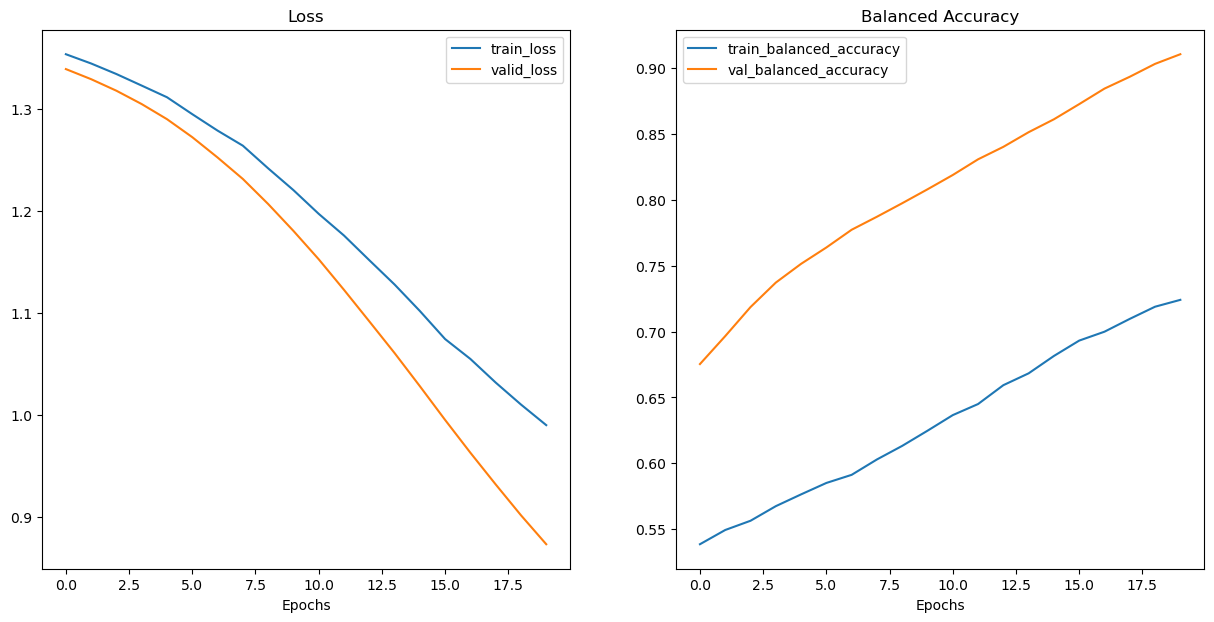

In [398]:
helper_functions.plot_loss_curves(results)